# Tutorial 07

## template fitting mock data test (T mode, non-parametric CMB)

`simple likelihood`:

$$ -2\log\mathcal{L} = (\hat{X}-\bar{N}-X)^T \mathcal{M}_f^{-1} (\hat{X}-\bar{N}-X) $$

$$ X = vecp(D) $$

$$ M_f = Cov(X_f+N) $$

`H-L likelihood`:

$$ -2\log\mathcal{L} \propto vecp(D^fg[\frac{\hat{D}}{D+N}])^T \mathcal{M}_f^{-1} vecp(D^fg[\frac{\hat{D}}{D+N}]) $$

In [1]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
import matplotlib.gridspec as gsp
import afra as af
from afra.tools.ps_estimator import pstimator
from afra.tools.fg_models import syncmodel, dustmodel, syncdustmodel
from afra.tools.bg_models import cmbmodel
import seaborn as sns
from dynesty import plotting as dyplot
import warnings
warnings.filterwarnings('ignore')

NSIDE = 128
fwhm = [0.5*np.pi/180.,0.3*np.pi/180.,0.2*np.pi/180.,0.08*np.pi/180.]  # FWHM for beam effect

map30f = hp.read_map('./data/pysm_s1d1_30.fits',field=[0,1,2],dtype=np.float32,verbose=0)
map95f = hp.read_map('./data/pysm_s1d1_95.fits',field=[0,1,2],dtype=np.float32,verbose=0)
map150f = hp.read_map('./data/pysm_s1d1_150.fits',field=[0,1,2],dtype=np.float32,verbose=0)
map353f = hp.read_map('./data/pysm_s1d1_353.fits',field=[0,1,2],dtype=np.float32,verbose=0)
cmb_cl = hp.read_cl('./data/camb_cls.fits')

vmap30 = hp.read_map('./data/plkvar_30.fits',field=[0,1,2],dtype=np.float32,verbose=0)
vmap95 = hp.read_map('./data/alivar_95.fits',field=[0,1,2],dtype=np.float32,verbose=0)
vmap150 = hp.read_map('./data/alivar_150.fits',field=[0,1,2],dtype=np.float32,verbose=0)
vmap353 = hp.read_map('./data/plkvar_353.fits',field=[0,1,2],dtype=np.float32,verbose=0)

nmap30 = np.random.normal(0.,1.,size=vmap30.shape)*np.sqrt(vmap30)
nmap95 = np.random.normal(0.,1.,size=vmap95.shape)*np.sqrt(vmap95)
nmap150 = np.random.normal(0.,1.,size=vmap150.shape)*np.sqrt(vmap150)
nmap353 = np.random.normal(0.,1.,size=vmap353.shape)*np.sqrt(vmap353)

ell = np.arange(cmb_cl.shape[1])
mapcmb = hp.synfast(cmb_cl,nside=NSIDE,new=True,verbose=0)
map30 = hp.smoothing(mapcmb+map30f,fwhm=fwhm[0],verbose=0)+nmap30
map95 = hp.smoothing(mapcmb+map95f,fwhm=fwhm[1],verbose=0)+nmap95
map150 = hp.smoothing(mapcmb+map150f,fwhm=fwhm[2],verbose=0)+nmap150
map353 = hp.smoothing(mapcmb+map353f,fwhm=fwhm[3],verbose=0)+nmap353

mask = hp.read_map('./data/ali_mask.fits',dtype=bool,verbose=0)

#### 1st run with sync model (simple likelihood)

- mock data frequencies: 95, 150
- template frequency: 30
- multipole bin-width: 80
- mask: Ali
- apodization: True, 6 deg
- map variances: Plk, Ali
- foreground model: templated powerlaw

iter: 16 | bound: 0 | nc: 1 | ncall: 1016 | eff(%):  1.575 | loglstar:   -inf < -10862.231 <    inf | logz: -10869.848 +/-  0.123 | dlogz: 10974.504 >  1.009                                         

fg truths:  {'beta_s': -3.0}
cmb truths:  {'bp_c_T_79.49999999999991': 2047.5421461519068, 'bp_c_T_139.4999999999998': 4041.083772791887}


iter: 8588 | +1000 | bound: 9 | nc: 1 | ncall: 47983 | eff(%): 19.982 | loglstar:   -inf < -0.001 <    inf | logz: -8.344 +/-  0.121 | dlogz:  0.001 >  1.009                                         

CPU times: user 17min 12s, sys: 6.44 s, total: 17min 18s
Wall time: 2min 28s


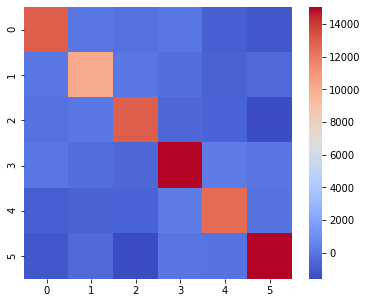

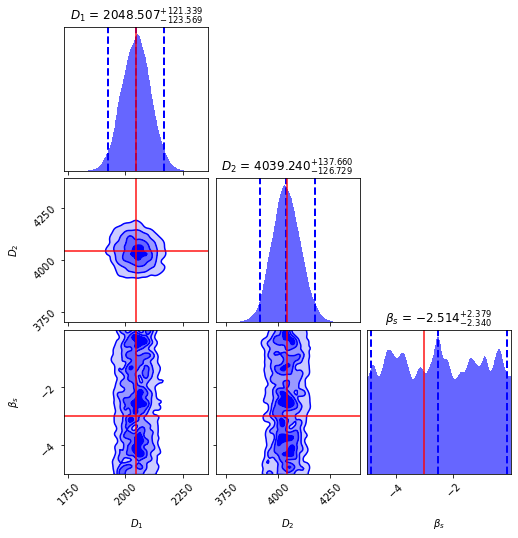

In [2]:
%%time

FREQS = [95.,150.]
NMAP = 1
RESAMP = 30
APOSCALE = 6.
PSBIN = 60
LMIN = 50
LMAX = 200

fullmap = dict()
fullmap[95] = map95[0].reshape(1,-1)
fullmap[150] = map150[0].reshape(1,-1)

fullvar = dict()
fullvar[95] = vmap95[0].reshape(1,-1)
fullvar[150] = vmap150[0].reshape(1,-1)

fullbeam = dict()
fullbeam[95] = fwhm[1]
fullbeam[150] = fwhm[2]

pipeline = af.tpfpipe(fullmap,mask=mask.reshape(1,-1),variances=fullvar,fwhms=fullbeam,likelihood='simple')
pre_rslt = pipeline.preprocess(aposcale=APOSCALE,psbin=PSBIN,lmin=LMIN,lmax=LMAX,nsamp=RESAMP)

fig,ax = plt.subplots(figsize=(6,5))
sns.heatmap(pre_rslt[3],cmap='coolwarm',annot=False,ax=ax)

tmpmap = dict()
tmpmap[30] = map30f[0].reshape(1,-1)

s = syncmodel(freqs=FREQS,nmap=NMAP,mask=mask.reshape(1,-1),aposcale=APOSCALE,psbin=PSBIN,lmin=LMIN,lmax=LMAX,
              templates=tmpmap,template_fwhms=None)
s.reset({'beta_s': -3.})

b = cmbmodel(freqs=FREQS,nmap=NMAP,mask=mask.reshape(1,-1),aposcale=APOSCALE,psbin=PSBIN,lmin=LMIN,lmax=LMAX)

# update CMB band powers by realistic values
est = pstimator(nside=NSIDE,mask=mask.reshape(1,-1),aposcale=APOSCALE,psbin=PSBIN,lmin=LMIN,lmax=LMAX)
auto_cmb_t = est.auto_t(mapcmb[0].reshape(1,-1))
for i in range(len(auto_cmb_t[0])):
    name = 'bp_c_T_'+str(auto_cmb_t[0][i])
    b.reset({name: auto_cmb_t[1][i]})
    
print ('fg truths: ',s.params)
print ('cmb truths: ',b.params)

mock_bp = s.bandpower()+b.bandpower()

KWARGS = {'nlive':1000}

pipeline.background = b
pipeline.foreground = s
result = pipeline.analyse(mock_bp+pre_rslt[2],pre_rslt[1],pre_rslt[2],pre_rslt[3],kwargs=KWARGS)

truths = list(auto_cmb_t[1]) + [-3]
labels = [r'$D_1$',r'$D_2$',r'$\beta_s$']

fg, ax = dyplot.cornerplot(result, color='blue', truths=truths,
                           labels=labels, use_math_text=True,
                           truth_color='red', show_titles=True,title_fmt='.3f',
                           max_n_ticks=3, quantiles=[0.025, 0.5, 0.975])

- with HL likelihood

iter: 7196 | +1000 | bound: 7 | nc: 1 | ncall: 45399 | eff(%): 18.053 | loglstar:   -inf < -0.004 <    inf | logz: -6.989 +/-  0.112 | dlogz:  0.001 >  1.009                                         

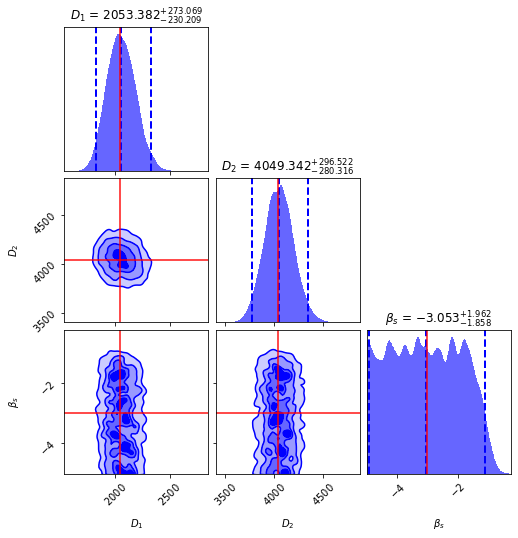

In [3]:
KWARGS = {'nlive':1000}

pipeline.likelihood='hl'
result = pipeline.analyse(mock_bp+pre_rslt[2],pre_rslt[1],pre_rslt[2],pre_rslt[3],kwargs=KWARGS)

truths = list(auto_cmb_t[1]) + [-3.]
labels = [r'$D_1$',r'$D_2$',r'$\beta_s$']
        
fg, ax = dyplot.cornerplot(result, color='blue', truths=truths,
                           labels=labels, use_math_text=True,
                           truth_color='red', show_titles=True,title_fmt='.3f',
                           max_n_ticks=3, quantiles=[0.025, 0.5, 0.975])

#### 2nd run with dust model

- mock data frequencies: 95, 150
- template frequency: 353
- multipole bin-width: 80
- mask: Ali
- apodization: True, 6 deg
- map variances: Plk, Ali
- foreground model: templated modified blackbody

iter: 1 | bound: 0 | nc: 1 | ncall: 1001 | eff(%):  0.100 | loglstar:   -inf < -8961.772 <    inf | logz: -8969.374 +/-  0.123 | dlogz:    inf >  1.009                                               

fg truths:  {'beta_d': 1.5}
cmb truths:  {'bp_c_T_79.49999999999991': 2047.5421461519068, 'bp_c_T_139.4999999999998': 4041.083772791887}


iter: 8269 | +1000 | bound: 9 | nc: 1 | ncall: 49555 | eff(%): 18.704 | loglstar:   -inf < -0.001 <    inf | logz: -8.030 +/-  0.118 | dlogz:  0.001 >  1.009                                         

CPU times: user 16min 58s, sys: 2.52 s, total: 17min 1s
Wall time: 2min 26s


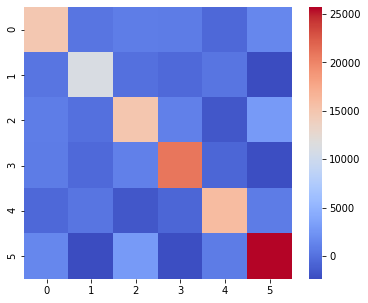

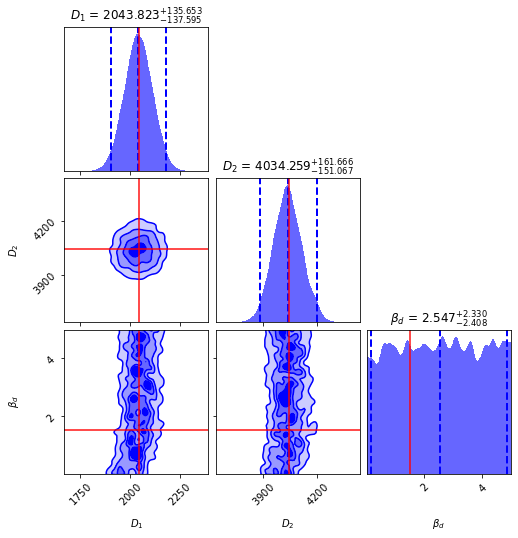

In [4]:
%%time

FREQS = [95.,150.]
NMAP = 1
RESAMP = 30
APOSCALE = 6.
PSBIN = 60
LMIN = 50
LMAX = 200

fullmap = dict()
fullmap[95] = map95[0].reshape(1,-1)
fullmap[150] = map150[0].reshape(1,-1)

fullvar = dict()
fullvar[95] = vmap95[0].reshape(1,-1)
fullvar[150] = vmap150[0].reshape(1,-1)

fullbeam = dict()
fullbeam[95] = fwhm[1]
fullbeam[150] = fwhm[2]

pipeline = af.tpfpipe(fullmap,mask=mask.reshape(1,-1),variances=fullvar,fwhms=fullbeam)
pre_rslt = pipeline.preprocess(aposcale=APOSCALE,psbin=PSBIN,lmin=LMIN,lmax=LMAX,nsamp=RESAMP)

fig,ax = plt.subplots(figsize=(6,5))
sns.heatmap(pre_rslt[3],cmap='coolwarm',annot=False,ax=ax)

tmpmap = dict()
tmpmap[353] = map353f[0].reshape(1,-1)

d = dustmodel(freqs=FREQS,nmap=NMAP,mask=mask.reshape(1,-1),aposcale=APOSCALE,psbin=PSBIN,lmin=LMIN,lmax=LMAX,
              templates=tmpmap,template_fwhms=None)
d.reset({'beta_d':1.5})

b = cmbmodel(freqs=FREQS,nmap=NMAP,mask=mask.reshape(1,-1),aposcale=APOSCALE,psbin=PSBIN,lmin=LMIN,lmax=LMAX)

# update CMB band powers by realistic values
est = pstimator(nside=NSIDE,mask=mask.reshape(1,-1),aposcale=APOSCALE,psbin=PSBIN,lmin=LMIN,lmax=LMAX)
auto_cmb_t = est.auto_t(mapcmb[0].reshape(1,-1))
for i in range(len(auto_cmb_t[0])):
    name = 'bp_c_T_'+str(auto_cmb_t[0][i])
    b.reset({name: auto_cmb_t[1][i]})
    
print ('fg truths: ',d.params)
print ('cmb truths: ',b.params)

mock_bp = d.bandpower()+b.bandpower()

KWARGS = {'nlive':1000}

pipeline.background = b
pipeline.foreground = d
result = pipeline.analyse(mock_bp+pre_rslt[2],pre_rslt[1],pre_rslt[2],pre_rslt[3],kwargs=KWARGS)

truths = list(auto_cmb_t[1]) + [1.5]
labels = [r'$D_1$',r'$D_2$',r'$\beta_d$']

fg, ax = dyplot.cornerplot(result, color='blue', truths=truths,
                           labels=labels, use_math_text=True,
                           truth_color='red', show_titles=True,title_fmt='.3f',
                           max_n_ticks=3, quantiles=[0.025, 0.5, 0.975])

- with HL likelihood

iter: 10613 | +1000 | bound: 12 | nc: 1 | ncall: 52862 | eff(%): 21.969 | loglstar:   -inf < -0.000 <    inf | logz: -10.507 +/-  0.148 | dlogz:  0.001 >  1.009                                      

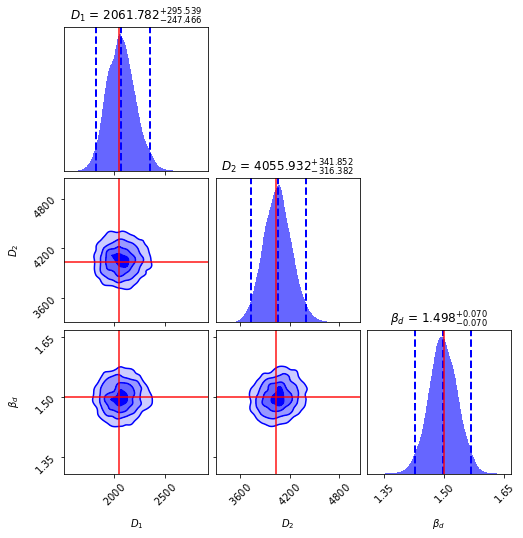

In [5]:
KWARGS = {'nlive':1000}

pipeline.likelihood = 'hl'
result = pipeline.analyse(mock_bp+pre_rslt[2],pre_rslt[1],pre_rslt[2],pre_rslt[3],kwargs=KWARGS)

truths = list(auto_cmb_t[1]) + [1.5]
labels = [r'$D_1$',r'$D_2$',r'$\beta_d$']

fg, ax = dyplot.cornerplot(result, color='blue', truths=truths,
                           labels=labels, use_math_text=True,
                           truth_color='red', show_titles=True,title_fmt='.3f',
                           max_n_ticks=3, quantiles=[0.025, 0.5, 0.975])

#### 3rd run with sync+dust model

- mock data frequencies: 95, 150
- template frequency: 30, 353
- multipole bin-width: 80
- mask: Ali
- apodization: True, 6 deg
- map variances: Plk, Ali
- foreground model: templated powerlaw and templated modified blackbody

fg truths:  {'beta_s': -3.0, 'beta_d': 1.5, 'rho': 0.0}
cmb truths:  {'bp_c_T_79.49999999999991': 2047.5421461519068, 'bp_c_T_139.4999999999998': 4041.083772791887}


iter: 8581 | +1000 | bound: 11 | nc: 1 | ncall: 51593 | eff(%): 18.570 | loglstar:   -inf < -0.001 <    inf | logz: -8.346 +/-  0.121 | dlogz:  0.001 >  1.009                                        

CPU times: user 24min 7s, sys: 3.88 s, total: 24min 11s
Wall time: 3min 28s


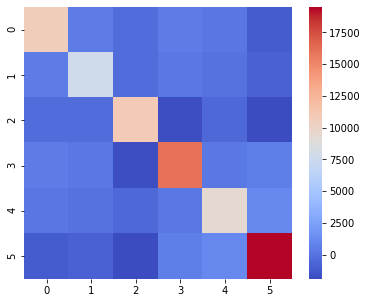

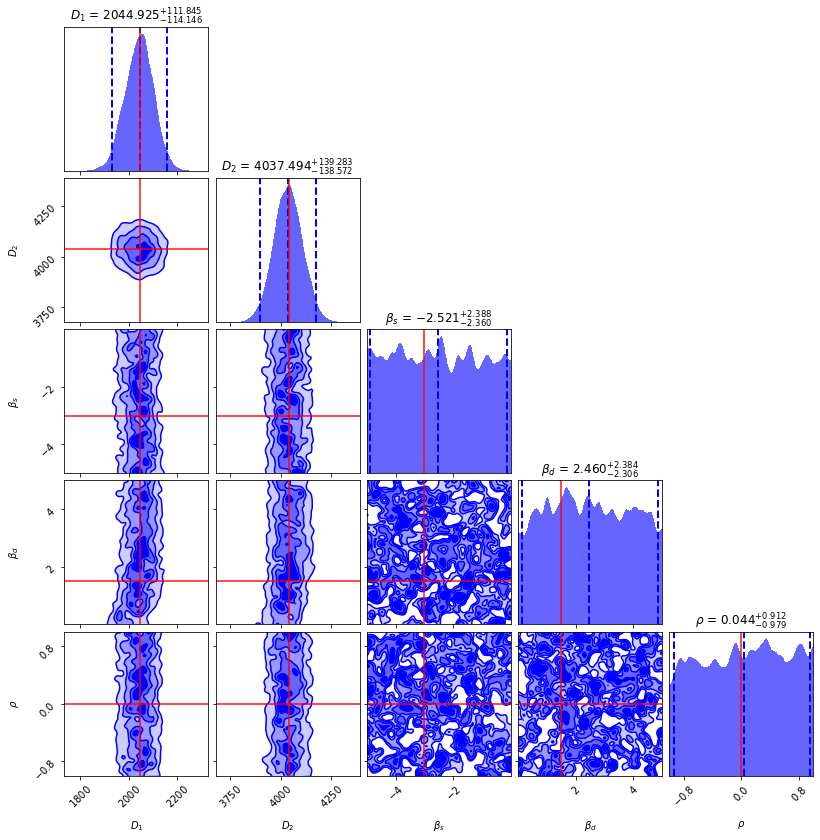

In [6]:
%%time

FREQS = [95.,150.]
NMAP = 1
RESAMP = 40
APOSCALE = 6.
PSBIN = 60
LMIN = 50
LMAX = 200

fullmap = dict()
fullmap[95] = map95[0].reshape(1,-1)
fullmap[150] = map150[0].reshape(1,-1)

fullvar = dict()
fullvar[95] = vmap95[0].reshape(1,-1)
fullvar[150] = vmap150[0].reshape(1,-1)

fullbeam = dict()
fullbeam[95] = fwhm[1]
fullbeam[150] = fwhm[2]

pipeline = af.tpfpipe(fullmap,mask=mask.reshape(1,-1),variances=fullvar,fwhms=fullbeam)
pre_rslt = pipeline.preprocess(aposcale=APOSCALE,psbin=PSBIN,lmin=LMIN,lmax=LMAX,nsamp=RESAMP)

fig,ax = plt.subplots(figsize=(6,5))
sns.heatmap(pre_rslt[3],cmap='coolwarm',annot=False,ax=ax)

tmpmap = dict()
tmpmap[30] = map30f[0].reshape(1,-1)
tmpmap[353] = map353f[0].reshape(1,-1)

c = syncdustmodel(freqs=FREQS,nmap=NMAP,mask=mask.reshape(1,-1),aposcale=APOSCALE,psbin=PSBIN,lmin=LMIN,lmax=LMAX,
                  templates=tmpmap,template_fwhms=None)
c.reset({'beta_s':-3.})
c.reset({'beta_d':1.5})

b = cmbmodel(freqs=FREQS,nmap=NMAP,mask=mask.reshape(1,-1),aposcale=APOSCALE,psbin=PSBIN,lmin=LMIN,lmax=LMAX)

# update CMB band powers by realistic values
est = pstimator(nside=NSIDE,mask=mask.reshape(1,-1),aposcale=APOSCALE,psbin=PSBIN,lmin=LMIN,lmax=LMAX)
auto_cmb_t = est.auto_t(mapcmb[0].reshape(1,-1))
for i in range(len(auto_cmb_t[0])):
    name = 'bp_c_T_'+str(auto_cmb_t[0][i])
    b.reset({name: auto_cmb_t[1][i]})
    
print ('fg truths: ',c.params)
print ('cmb truths: ',b.params)

mock_bp = c.bandpower()+b.bandpower()

KWARGS = {'nlive':1000}

pipeline.background = b
pipeline.foreground = c
result = pipeline.analyse(mock_bp+pre_rslt[2],pre_rslt[1],pre_rslt[2],pre_rslt[3],kwargs=KWARGS)

truths = list(auto_cmb_t[1]) + [-3.,1.5,0.]
labels = [r'$D_1$',r'$D_2$',r'$\beta_s$',r'$\beta_d$',r'$\rho$']

fg, ax = dyplot.cornerplot(result, color='blue', truths=truths,
                           labels=labels, use_math_text=True,
                           truth_color='red', show_titles=True,title_fmt='.3f',
                           max_n_ticks=3, quantiles=[0.025, 0.5, 0.975])

- with HL likelihood

iter: 11230 | +1000 | bound: 17 | nc: 1 | ncall: 61988 | eff(%): 19.730 | loglstar:   -inf < -0.025 <    inf | logz: -11.123 +/-  0.150 | dlogz:  0.001 >  1.009                                      

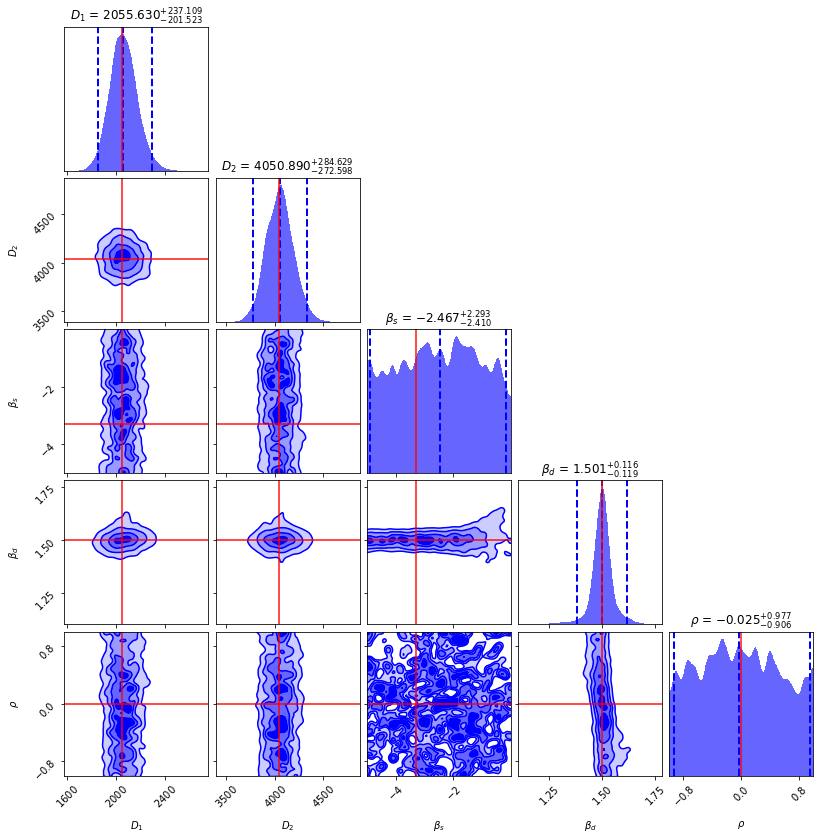

In [7]:
KWARGS = {'nlive':1000}

pipeline.likelihood = 'hl'
result = pipeline.analyse(mock_bp+pre_rslt[2],pre_rslt[1],pre_rslt[2],pre_rslt[3],kwargs=KWARGS)

truths = list(auto_cmb_t[1]) + [-3.3,1.5,0.]
labels = [r'$D_1$',r'$D_2$',r'$\beta_s$',r'$\beta_d$',r'$\rho$']

fg, ax = dyplot.cornerplot(result, color='blue', truths=truths,
                           labels=labels, use_math_text=True,
                           truth_color='red', show_titles=True,title_fmt='.3f',
                           max_n_ticks=3, quantiles=[0.025, 0.5, 0.975])

end